# New York City Taxi Trips

We would like to make a heatmap of showing the relationship between the price of a taxi trip and the tip amount as this can reveal patterns in tipping strategies. This task is challenging and requires knowledge of Spark and Python. Look at the solution for clues.

The dataset we will work on is published by the New York City Taxi and Limousine Commision, which since 2009 have been publishing data on every taxi trip in New York. There ara many taxitrips in New York every day, so this amounts to quite a lot of data. There are many different types of analysis that can be done on this data, but we will concentrate on illustrating how much people are tipping.

Since we will be working with more data it is good to be able to keep an eye on the jobs running on the Spark cluster. The code below is just to get a link to the SparkUI.

In [109]:
from IPython.display import Javascript
Javascript("""
           var el=document.createElement("h3");
           var ela=document.createElement("a");
           ela.innerHTML="SparkUI";
           ela.href=window.location.protocol + '//' + window.location.hostname + ':8088/proxy/""" \
           + spark.sparkContext.applicationId \
           + """/';
           ela.target="_blank";
           el.append(ela);
           
           element.append(el);
           """)

<IPython.core.display.Javascript object>

Even if we have several years of data we will just load one month of data from january 2012.

In [2]:
data = spark.read.csv("gs://big-data-course-datasets/nyc_taxi/yellow_tripdata_2012-01.csv",  \
             header=True).rdd.cache()

Even just one month of data is almost 15 mio. trips, so that should be enough to get a nice heatmap. 

In [4]:
data.count()

14969132

If we take a look at the data we can see that the relevant columns are "tip_amount" and "fare_amount"

In [5]:
data.toDF().show()

+---------+-------------------+-------------------+---------------+-------------------+-------------------+------------------+---------+------------------+-------------------+------------------+------------+------------------+---------+-------+------------------+------------------+------------------+
|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|      trip_distance|   pickup_longitude|   pickup_latitude|rate_code|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|       fare_amount|surcharge|mta_tax|        tip_amount|      tolls_amount|      total_amount|
+---------+-------------------+-------------------+---------------+-------------------+-------------------+------------------+---------+------------------+-------------------+------------------+------------+------------------+---------+-------+------------------+------------------+------------------+
|      CMT|2012-01-10 23:55:50|2012-01-11 00:03:39|              1|                1.7|-73.994

Try to create a heatmap showing "fare_amount" on the x-axis and "tip_amount" on the y-axis.

To make the heatmap we will need to put both data into some buckets. If we round off the fare and tip amounts to then nearest 10 cents we will have a reasonable resolution for the heatmap.

In [11]:
data.map(lambda x: { "fare": round(float(x["fare_amount"]),1), "tip": round(float(x["tip_amount"]),1)}).take(20)

[{'fare': 6.9, 'tip': 1.0},
 {'fare': 6.1, 'tip': 0.0},
 {'fare': 45.0, 'tip': 10.1},
 {'fare': 6.9, 'tip': 1.0},
 {'fare': 5.7, 'tip': 0.0},
 {'fare': 6.1, 'tip': 0.0},
 {'fare': 36.5, 'tip': 0.0},
 {'fare': 6.5, 'tip': 0.0},
 {'fare': 10.9, 'tip': 0.0},
 {'fare': 3.7, 'tip': 0.0},
 {'fare': 6.1, 'tip': 1.0},
 {'fare': 16.9, 'tip': 0.0},
 {'fare': 12.5, 'tip': 0.0},
 {'fare': 4.5, 'tip': 1.2},
 {'fare': 9.7, 'tip': 0.0},
 {'fare': 6.9, 'tip': 1.5},
 {'fare': 5.7, 'tip': 1.2},
 {'fare': 7.3, 'tip': 0.0},
 {'fare': 4.1, 'tip': 0.0},
 {'fare': 7.7, 'tip': 2.0}]

So inspecting the data a little bit it seems reasonable to plot fares up to 50 dollars and tips up to 20 dollars. Also, there are a lot of zeros in the data. We are not really interested in these, so we will set a minimum fare and tip of 10 cents.

In [58]:
min_fare = 0.1
max_fare = 50.0
min_tip = 0.1
max_tip = 20.0

count_data=data.map(lambda x: { "fare": round(float(x["fare_amount"]),1), "tip": round(float(x["tip_amount"]),1)}) \
                    .filter(lambda x: x["fare"] > min_fare and x["fare"] < max_fare \
                            and x["tip"] > min_tip and x["tip"] < max_tip) \
                    .map(lambda x: ((x["fare"], x["tip"]), 1)) \
                    .reduceByKey(lambda x,y: x+y) \
                    .map(lambda x: {"fare": x[0][0], "tip":x[0][1], "count":x[1]})


We can reduce the counts into the buckets by setting key to be the combination of fare and tip. That gives us a total number of possible bucket of 499 x 199 = 99 301. But if we count the output we get a much lower number.

In [59]:
count_data.count()

13095

The reason for the lower number of buckets than expected is that zeros are not included. At this stage we could just collect the data and fix that problem in Python, but lets see how to solve this in Spark.

What we can do is to create a dataset with zeros in all buckets and reduce that together with the actual data.

In [138]:
zeros=[]
for fare in range(round(min_fare*10), round(max_fare*10)):
    for tip in range(round(min_tip*10), round(max_tip*10)):
        zeros.append({"fare": fare/10, "tip": tip/10, "count": 0})
zero_fill=spark.sparkContext.parallelize(zeros)

In [139]:
zero_fill.count()

99301

In [140]:
zero_fill.take(20)

[{'fare': 0.1, 'tip': 0.1, 'count': 0},
 {'fare': 0.1, 'tip': 0.2, 'count': 0},
 {'fare': 0.1, 'tip': 0.3, 'count': 0},
 {'fare': 0.1, 'tip': 0.4, 'count': 0},
 {'fare': 0.1, 'tip': 0.5, 'count': 0},
 {'fare': 0.1, 'tip': 0.6, 'count': 0},
 {'fare': 0.1, 'tip': 0.7, 'count': 0},
 {'fare': 0.1, 'tip': 0.8, 'count': 0},
 {'fare': 0.1, 'tip': 0.9, 'count': 0},
 {'fare': 0.1, 'tip': 1.0, 'count': 0},
 {'fare': 0.1, 'tip': 1.1, 'count': 0},
 {'fare': 0.1, 'tip': 1.2, 'count': 0},
 {'fare': 0.1, 'tip': 1.3, 'count': 0},
 {'fare': 0.1, 'tip': 1.4, 'count': 0},
 {'fare': 0.1, 'tip': 1.5, 'count': 0},
 {'fare': 0.1, 'tip': 1.6, 'count': 0},
 {'fare': 0.1, 'tip': 1.7, 'count': 0},
 {'fare': 0.1, 'tip': 1.8, 'count': 0},
 {'fare': 0.1, 'tip': 1.9, 'count': 0},
 {'fare': 0.1, 'tip': 2.0, 'count': 0}]

The Spark function **union()** allows us to concatenate two RDDs into one and we can then solve the problem by reducing twice.

In [133]:
count_data_fill=data.map(lambda x: { "fare": round(float(x["fare_amount"]),1), "tip": round(float(x["tip_amount"]),1)}) \
                    .filter(lambda x: x["fare"] > min_fare and x["fare"] < max_fare \
                            and x["tip"] > min_tip and x["tip"] < max_tip) \
                    .map(lambda x: ((x["fare"], x["tip"]), 1)) \
                    .reduceByKey(lambda x,y: x+y) \
                    .map(lambda x: {"fare": x[0][0], "tip":x[0][1], "count":x[1]}) \
                    .union(zero_fill) \
                    .map(lambda x: ((x["fare"], x["tip"]), x["count"])) \
                    .reduceByKey(lambda x,y: x+y) \
                    .map(lambda x: {"fare": x[0][0], "tip":x[0][1], "count":x[1]}) \
                    .cache()

If we just make a heatmap of the counts as they are, it will be very dark, but we can distribute the scale better by taking the log of the counts.

In [135]:
import math

def make_row(tip, list_of_farecounts):
    row={}
    row["tip"]=tip
    for farecount in list_of_farecounts:
        row[str(farecount["fare"])]=math.log(1+farecount["count"])
    return row

heatmap_data=count_data_fill.map(lambda x: (x["tip"], [{"count":x["count"], "fare": x["fare"]}])) \
        .reduceByKey(lambda x,y: x+y) \
        .map(lambda x: make_row(x[0], x[1]))
    
heatmap_data.take(10)

[{'tip': 16.6,
  '45.0': 0.6931471805599453,
  '11.0': 0.0,
  '12.5': 0.0,
  '16.0': 0.0,
  '34.5': 0.0,
  '37.9': 0.0,
  '41.0': 0.0,
  '25.6': 0.0,
  '31.5': 0.0,
  '42.4': 0.0,
  '43.4': 0.0,
  '44.2': 0.0,
  '0.9': 0.0,
  '2.6': 0.0,
  '4.9': 0.0,
  '6.7': 0.0,
  '7.3': 0.0,
  '17.0': 0.0,
  '18.4': 0.0,
  '22.6': 0.0,
  '23.3': 0.0,
  '23.4': 0.0,
  '11.2': 0.0,
  '11.5': 0.0,
  '14.3': 0.0,
  '35.4': 0.0,
  '16.5': 0.6931471805599453,
  '32.1': 0.0,
  '41.5': 0.0,
  '42.9': 0.0,
  '43.9': 0.0,
  '44.4': 0.0,
  '45.5': 0.0,
  '1.1': 0.0,
  '2.7': 0.0,
  '17.5': 0.0,
  '18.9': 0.0,
  '20.2': 0.0,
  '20.8': 0.0,
  '21.1': 0.0,
  '21.8': 0.0,
  '23.9': 0.0,
  '24.3': 0.0,
  '24.7': 0.0,
  '14.4': 0.0,
  '34.2': 0.0,
  '34.9': 0.0,
  '35.2': 0.0,
  '36.9': 0.0,
  '1.7': 0.0,
  '3.7': 0.0,
  '7.1': 0.0,
  '7.2': 0.0,
  '19.8': 0.0,
  '24.6': 0.0,
  '26.7': 0.0,
  '29.6': 0.0,
  '31.6': 0.0,
  '41.7': 0.0,
  '41.8': 0.0,
  '41.9': 0.0,
  '8.1': 1.0986122886681098,
  '8.3': 0.0,
  '9.5':

In [136]:
import pandas as pd

heatmap_dataframe = heatmap_data.toDF().toPandas() \
     .set_index("tip") \
     .reindex(sorted(heatmap_dataframe.columns, key=float), axis=1)

/usr/lib/spark/python/pyspark/sql/session.py:360: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


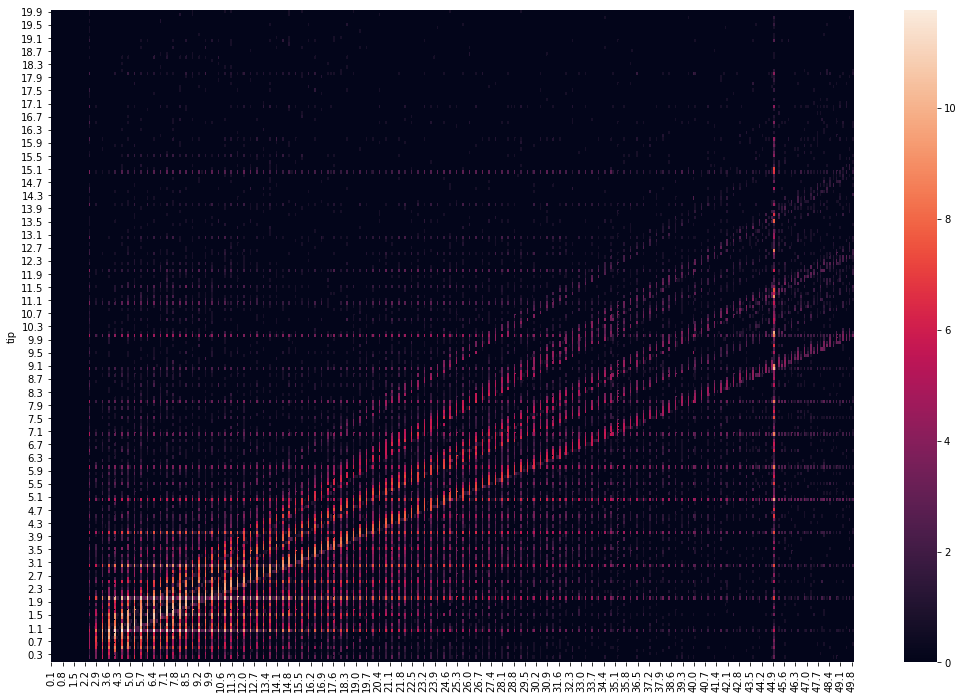

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(18, 12))
ax = sns.heatmap(heatmap_dataframe.sort_values(by="tip", ascending=False))

The heatmap reveals some patterns in the way people tip taxidrivers:

- What is the interpretation of the horizontal lines?
- What is the interpretation of the vertical lines?
- What is the interpretation of the diagonal lines?

We used an RDD called **heatmap_data**. If we had not just used one month of data but ten years of data. What would have been the size of this RDD?